In [1]:
import torch

from sbi import analysis as analysis
from sbi import utils as utils
from sbi.inference.base import infer
import matplotlib.pyplot as plt
from typing import Any, Dict, List, Optional, Tuple, Union
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from scipy.stats import binom, gaussian_kde
#from sbi.analysis.plot import _update, prepare_for_plot,_arrange_plots, probs2contours, get_diag_func, ensure_numpy,_format_axis
import matplotlib as mpl
from logging import warn
from sbi.analysis.plot import pairplot, marginal_plot, _get_default_fig_kwargs

In [2]:
from toy_posterior_for_07_cc import ExamplePosterior

posterior = ExamplePosterior()

In [3]:
x_o = torch.ones(1, 20)  # simulator output was 20-dimensional
posterior.set_default_x(x_o)

In [4]:
posterior_samples = posterior.sample((200,))

posterior_samples.shape

torch.Size([204, 3])

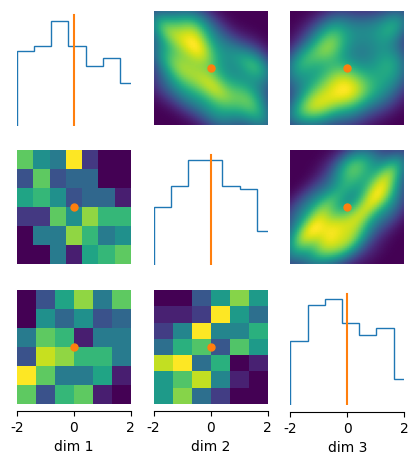

In [5]:

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, limits=[[-2, 2], [-2, 2], [-2, 2]], figsize=(5, 5),upper='kde',lower='hist',
    points=[[0,0,0]]
)

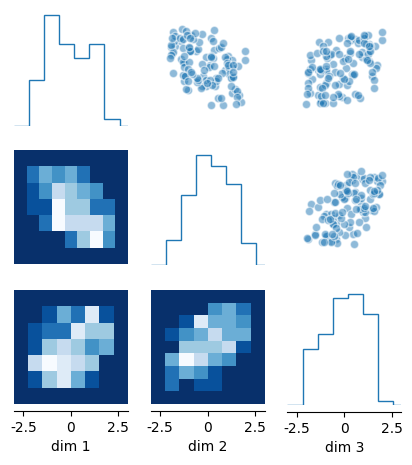

In [13]:

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, limits=[[-3, 3], [-3, 3], [-3, 3]], figsize=(5, 5),
    upper="scatter",
    upper_kwargs={"mpl_kwargs": {"color":'tab:blue'}},
    lower="hist",
    lower_kwargs={"mpl_kwargs": {"cmap": "Blues_r","vmin":0}},
)

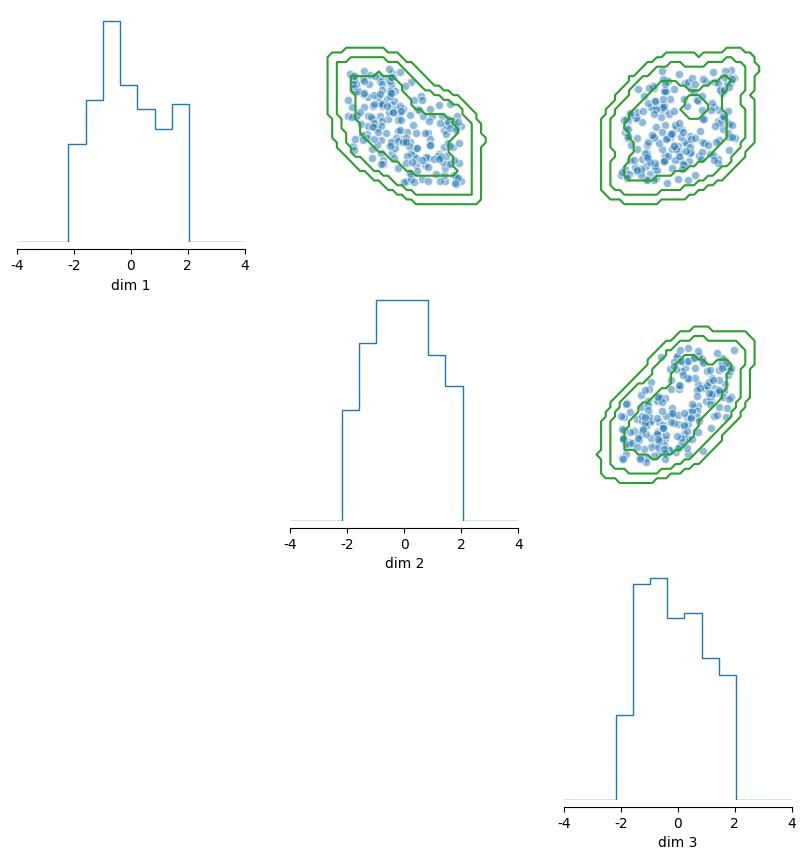

In [7]:

# plot posterior samples
_ = analysis.pairplot(
    [posterior_samples,posterior_samples], limits=[[-4, 4], [-4, 4], [-4, 4]],
    upper=["scatter",'contour'],
    diag = ["hist",None],
    )

In [8]:
fig_kwargs={"despine":{"offset":0}}

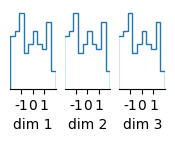

In [9]:
posterior_samples = posterior.sample((100,))
posterior_samples2 = posterior.sample((100,))

fig, ax = marginal_plot(diag =['hist',None], samples=[posterior_samples,posterior_samples2],
            diag_kwargs=[{'mpl_kwargs':{"bins":10,
                                        "alpha":1,
                                        "color":'tab:blue','density':True},
                        },{}],

            fig_kwargs = fig_kwargs,
             figsize=(2,1))

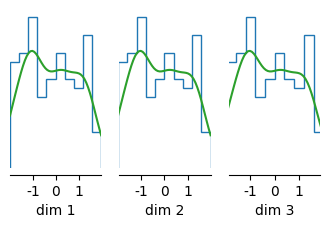

In [10]:

fig, ax = marginal_plot(diag =['hist','kde'], samples=[posterior_samples,posterior_samples],
                        diag_kwargs = [{'mpl_kwargs':{"density":True,"bins":10}},{}],
             figsize=(4,2))

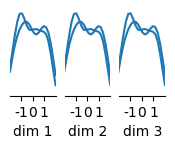

In [11]:
fig, ax = marginal_plot(diag ='kde', samples=[posterior_samples,posterior_samples2],
            diag_kwargs={'bins': 20,
                         'bw_method':'scott',
                          'mpl_kwargs':{
                                        "alpha":1,
                                        "color":'tab:blue'},

            },
             figsize=(2,1))


(<Figure size 200x100 with 3 Axes>,
 array([[<Axes: xlabel='dim 1'>, <Axes: xlabel='dim 2'>,
         <Axes: xlabel='dim 3'>]], dtype=object))

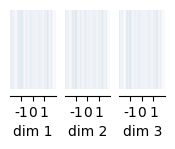

In [12]:
marginal_plot(diag ='scatter', samples=[posterior_samples,posterior_samples2],
            diag_kwargs={
                          'mpl_kwargs':{"lw":0.01,
                                        "alpha":1,
                                        "color":'tab:blue'}
            },
             figsize=(2,1))